# Part B Recurrent Neural Networks
| Name                  | Admin No. | Class          |
| --------------------- | --------- | -------------- |
| Ernest Ng Sheng Kang  | P2222668  | DAAA/FT/2B/06  |
## Background Infomation



## Initializing Libaries

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from wordcloud import WordCloud

## Checking GPU

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Setting Random Seed

In [4]:
seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

## Problem Statement
Our Goal of this project is to build a next-word predictor, given a sequence of words. Our model should also produce different sequences of words given the same input.
## Goals of this project
### Generalization
> We need a model that generalizes well to different input sequences beyond the training data.
### Accuracy of Predictions
> We need to make our model accurately predicts the next word in a given sequence, especially for the provided seed_texts. Idealy around 85% of our choosen evaluation metrics
### Variabilty in Output
> We need to create a model that is capable of producing different and diverse sequences for the same input.

# Importing Dataset

In [5]:
df = pd.read_csv('./datasets/train (1).csv')
print(df)

                                                Quotes
0    Embrace the beauty of every sunrise; it's a fr...
1    Embrace challenges; they are the stepping ston...
2    Embrace the rhythm of life and let it dance th...
3    Embrace kindness, for it has the power to chan...
4    Embrace the journey, for it leads to the desti...
..                                                 ...
995  With an open heart, welcome the opportunities ...
996  This morning, let your laughter be the music t...
997  In the serenity of this morning, find the powe...
998  This morning, let your actions be a testament ...
999  With each sunrise, this morning offers the pro...

[1000 rows x 1 columns]


In [6]:
print(f'There are {len(df)} quotes in this dataset.')
df.head(5)

There are 1000 quotes in this dataset.


,Quotes
0,Embrace the beauty of every sunrise; it's a fr...
1,Embrace challenges; they are the stepping ston...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."


# EDA
What insights can we get from our data?
- What is the frequency distribution of words in our dataset?
- What is the distribution of lengths of quotes from our dataset? Are there any outliers?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Quotes  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


### Checking for any Missing or Null Values

In [8]:
df.isnull().sum()

Quotes    0
dtype: int64

### Checking for duplicates

In [9]:
duplicates = df.duplicated()
print(f'Number of duplicate rows = {duplicates.sum()}')

Number of duplicate rows = 110


In [10]:
df = df.drop_duplicates()
df = df.reset_index(drop=True)
duplicate_rows = df.duplicated()
print(f'Number of duplicate rows = {duplicate_rows.sum()}')
df

Number of duplicate rows = 0


,Quotes
0,Embrace the beauty of every sunrise; it's a fr...
1,Embrace challenges; they are the stepping ston...
2,Embrace the rhythm of life and let it dance th...
3,"Embrace kindness, for it has the power to chan..."
4,"Embrace the journey, for it leads to the desti..."
...,...
885,"With an open heart, welcome the opportunities ..."
886,"This morning, let your laughter be the music t..."
887,"In the serenity of this morning, find the powe..."
888,"This morning, let your actions be a testament ..."


### Checking for Numerical values

In [11]:
is_numeric = df['Quotes'].apply(lambda x: str(x).isnumeric())
print(f'Number of numeric quotes = {is_numeric.sum()}')

Number of numeric quotes = 0


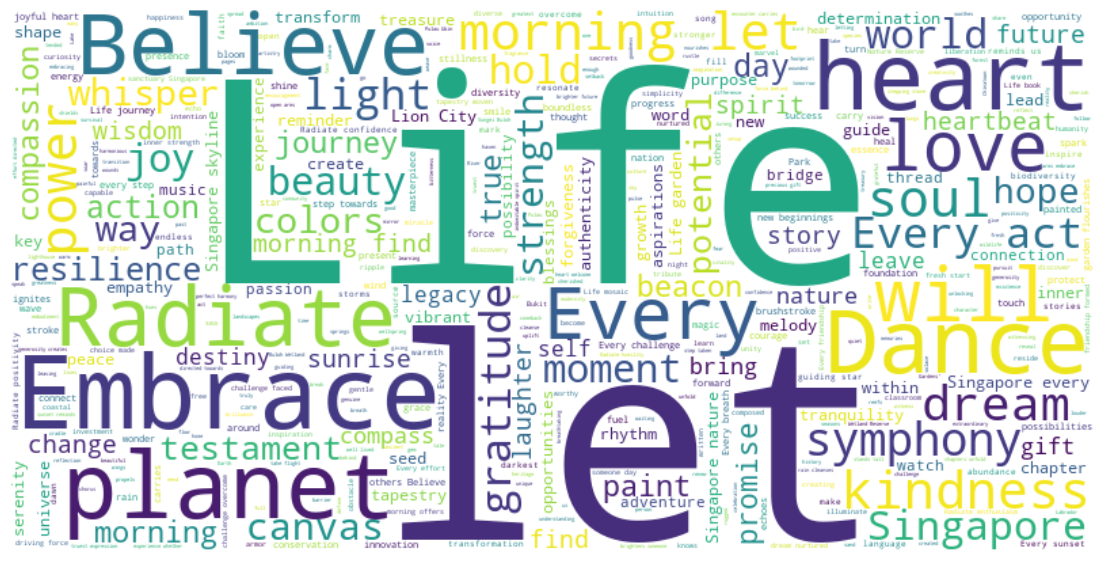

In [12]:
text = " ".join(quote for quote in df.Quotes)

# Create and generate a word cloud image
wordcloud = WordCloud(background_color="white", width=800, height=400, max_words=5000).generate(text)

# Display the generated image
plt.figure(figsize=(14,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Observations:
- We can see that the words, "Let" , "Life" , "Embrace" and "heart" are the most common words found in our dataset. 
- We would expect the words, "the","and" as the most common words but we dont see them.This happens because wordcloud automatically removes common stopswords like "the" "and" "is"  to focus on meaningful words and avoid cluttering the visualization with frequently occurring but less informative words.

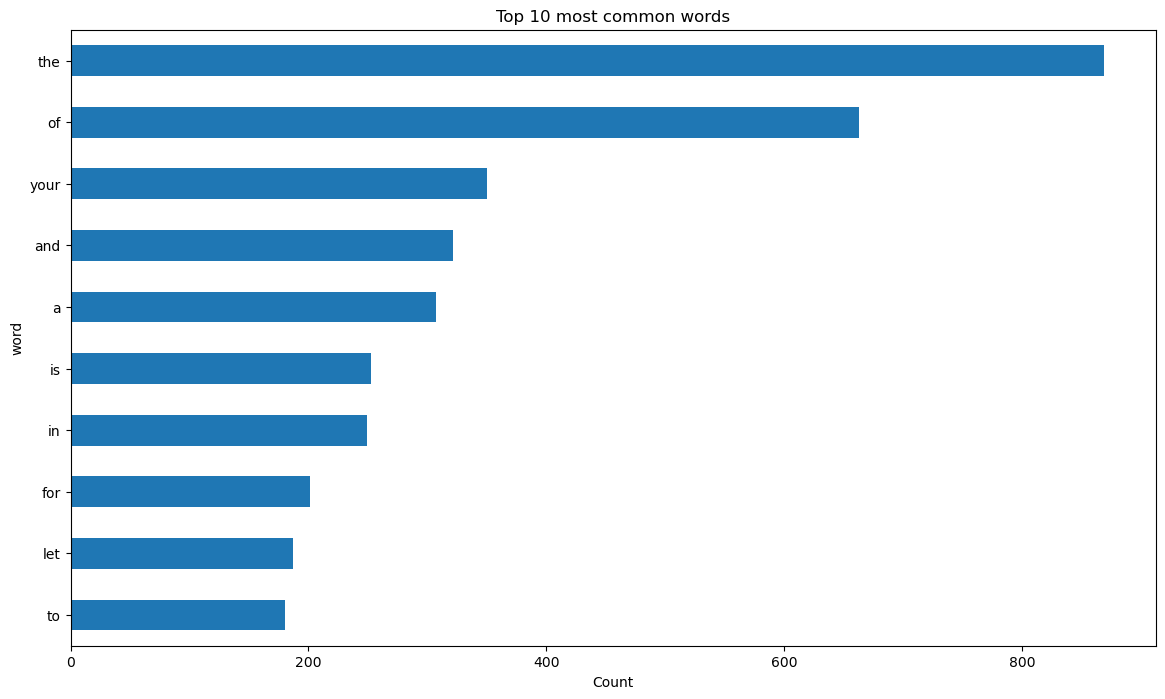

In [13]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(df['Quotes'])
word_counts = tokenizer.word_counts
common_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:10]

df_common_words = pd.DataFrame(common_words, columns=['word', 'count'])

df_common_words.sort_values(by='count').plot(kind='barh', x='word', y='count', legend=False,figsize=(14,8))
plt.xlabel('Count')
plt.title('Top 10 most common words')
plt.show()

Observations:
- The most frequent words are now the common stopwords like "the", "of", "your" and "and". 
- Without wordcloud automatically removing them we can see that all of the top 10 most common words found in our dataset are stop words.

In [14]:
num_unique_words = len(tokenizer.word_index) + 1 # +1 for padding
print(f'Number of unique words: {num_unique_words}')

Number of unique words: 1199


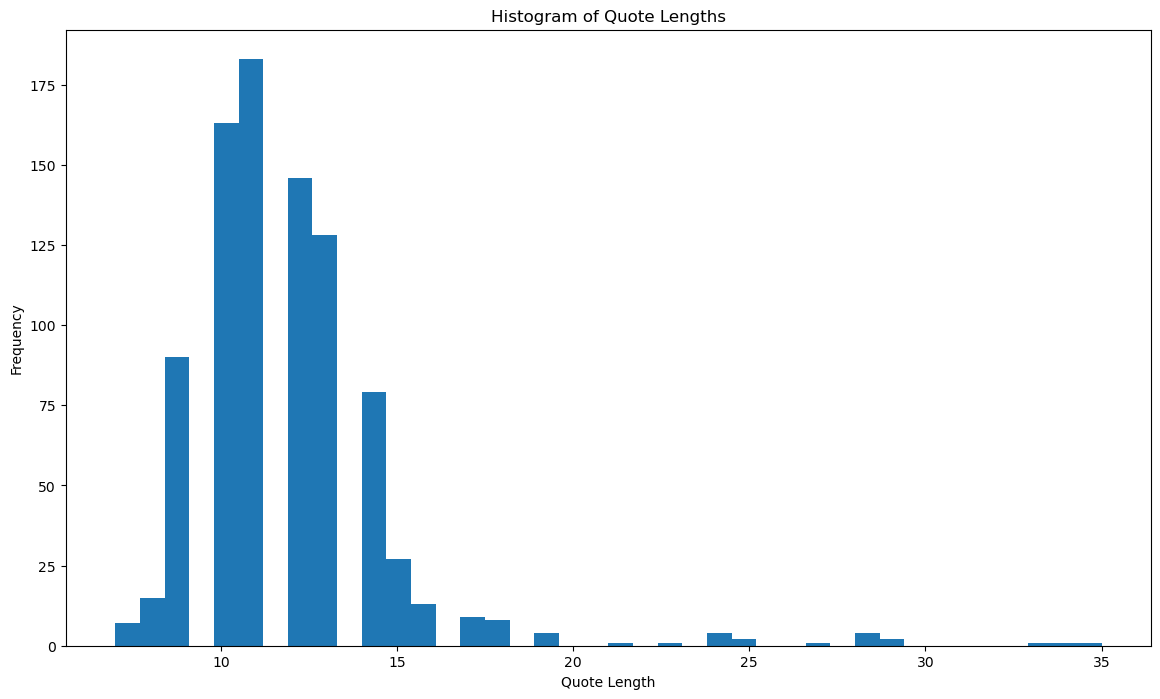

In [15]:
tokenizer = Tokenizer()
# Fit the tokenizer on the quotes
tokenizer.fit_on_texts(df['Quotes'])
# Get the sequences of tokens for each quote
sequences = tokenizer.texts_to_sequences(df['Quotes'])
# Get the word length of each quote
df['Quote Word Length'] = [len(seq) for seq in sequences]

# Create a histogram of quote lengths
df['Quote Word Length'].plot(kind='hist', bins=40,figsize=(14,8))
plt.xlabel('Quote Length')
plt.title('Histogram of Quote Lengths')
plt.show()

Observations:
- We can see that most quotes are around 10-12 words long, with a few outliers at around 35 words long
- We might need to pad sequences to a length slightly beyond our typical quote length to capture the majority of our quotes effectively.

### Phrase Analysis

In [16]:
for i in range(2,5):
    vectorizer = CountVectorizer(ngram_range=(i, i))
    X = vectorizer.fit_transform(df['Quotes'])
    df_ngrams = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    bigram_counts = df_ngrams.sum()
    common_ngrams = bigram_counts.nlargest(10)
    print(f'\nCommon {i}-grams:')
    print(common_ngrams)


Common 2-grams:
be the          126
let your        124
in the          101
this morning     97
of your          96
for it           93
our planet       92
embrace the      89
believe in       84
in yourself      83
dtype: int64

Common 3-grams:
believe in yourself    83
for it is              65
in yourself and        63
it is the              61
and you will           53
yourself and you       52
dance through the      51
this morning let       51
and let it             46
morning let your       41
dtype: int64

Common 4-grams:
believe in yourself and    63
for it is the              57
in yourself and you        52
yourself and you will      52
this morning let your      41
and let it be              38
let it be the              37
embrace the power of       25
believe in yourself for    20
of this morning find       20
dtype: int64


Observations:
- We can see from analysing our phrases that the sentiment of our text data is leaning more towards a motivational and positve tone.
    - Recurring motifs such as self-belief and taking action
    - We can see that many n-grams convey positive and motivational themes, encouraging personal growth, confidence, and positive actions.

# Data Preprocessing
- out of vocabilary
- contractions
- Tokenise the data
- handle missing and irelevant data
- Perform text cleaning, including removing stop words, punctuation, and special characters.
- Convert text data into a numerical format suitable for RNNs. (using neural network)

## Finding any unusual words in the English Language

In [17]:
nltk.download('words')
from nltk.corpus import words
words.readme().replace('\n', ' ')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


'Wordlists  en: English, http://en.wikipedia.org/wiki/Words_(Unix) en-basic: 850 English words: C.K. Ogden in The ABC of Basic English (1932) '

In [18]:
from nltk import word_tokenize
text_tokenized = df['Quotes'].apply(word_tokenize)
english_vocab = set(w.lower() for w in words.words())

text_vocab = set(w.lower() for quote in text_tokenized for w in quote if w.isalpha() and not w.endswith(('s', 'ing', 'ed', 'er', 'ly','est')))

unusual = text_vocab.difference(english_vocab)

print(unusual)

{'skyline', 'changi', 'sungei', 'jawa', 'merlion', 'peranakan', 'macritchie', 'brushstroke', 'hantu', 'semakau', 'kranji', 'sentosa', 'soundtrack', 'chek', 'biodiversity', 'clarke', 'hindhede', 'wetland', 'ubin', 'buloh', 'batok', 'punggol', 'coney', 'tekong', 'asia', 'bukit', 'timah', 'jurong', 'pulau', 'singapore'}


Observations:
- We can see that most unusual words our code has found are words mostly used in Singapore's context, for example "punggol" where this is not an english word but in Malay.It suggests that, this text is unique in the context of Singapore where we have a mix of many different cultures and thus implement words from all types of langugaes apart from English in our daily speaking habits.

## Cleaning our Text
We will be cleaning our text from punctuation, 
removing any special characters that may not convey meaningful information and lastly convert all our text to lowercase to ensure uniformity

In [19]:
import string

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Remove special characters
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    return text

# Apply text cleaning to the 'Quotes' column
df['Quotes'] = df['Quotes'].apply(clean_text)
df

,Quotes,Quote Word Length
0,embrace the beauty of every sunrise its a fres...,16
1,embrace challenges they are the stepping stone...,11
2,embrace the rhythm of life and let it dance th...,12
3,embrace kindness for it has the power to chang...,16
4,embrace the journey for it leads to the destin...,12
...,...,...
885,with an open heart welcome the opportunities a...,15
886,this morning let your laughter be the music th...,16
887,in the serenity of this morning find the power...,18
888,this morning let your actions be a testament t...,18


## Lemmitimizing our data
It involves reducing our words to their base or dictionary forms, known as lemmas. For example, the lemma of "dancing" is dance.

### How does it help?

## Input-Output pairs

In [20]:
#convert our df into a list
quotes = df['Quotes'].tolist()
quotes[:5]

['embrace the beauty of every sunrise its a fresh chance to paint your world with joy',
 'embrace challenges they are the stepping stones to your greatest victories',
 'embrace the rhythm of life and let it dance through your soul',
 'embrace kindness for it has the power to change the world one heart at a time',
 'embrace the journey for it leads to the destination of your dreams']

In [21]:
#tokenize our quotes
tokenizer = Tokenizer()
tokenizer.fit_on_texts(quotes)
print(tokenizer.word_index)

{'the': 1, 'of': 2, 'your': 3, 'and': 4, 'a': 5, 'is': 6, 'in': 7, 'for': 8, 'let': 9, 'to': 10, 'it': 11, 'be': 12, 'every': 13, 'our': 14, 'you': 15, 'that': 16, 'embrace': 17, 'lifes': 18, 'this': 19, 'are': 20, 'morning': 21, 'with': 22, 'radiate': 23, 'dance': 24, 'heart': 25, 'believe': 26, 'yourself': 27, 'through': 28, 'planets': 29, 'will': 30, 'life': 31, 'love': 32, 'they': 33, 'singapores': 34, 'kindness': 35, 'power': 36, 'from': 37, 'dreams': 38, 'we': 39, 'soul': 40, 'symphony': 41, 'act': 42, 'find': 43, 'gratitude': 44, 'singapore': 45, 'strength': 46, 'world': 47, 'light': 48, 'beauty': 49, 'journey': 50, 'nature': 51, 'joy': 52, 'planet': 53, 'canvas': 54, 'colors': 55, 'way': 56, 'whispers': 57, 'where': 58, 'potential': 59, 'hope': 60, 'testament': 61, 'resilience': 62, 'towards': 63, 'true': 64, 'new': 65, 'compassion': 66, 'hearts': 67, 'beacon': 68, 'actions': 69, 'future': 70, 'spirit': 71, 'step': 72, 'change': 73, 'wisdom': 74, 'moments': 75, 'promise': 76, '

In [22]:
total_words = len(tokenizer.word_index) + 1 # Because index 0 is reserved for padding.
print(total_words)

1200


In [23]:
for i in range(5):
    print(f'Quote {i+1}:')
    print(quotes[i])
    print(tokenizer.texts_to_sequences([quotes[i]])[0])

Quote 1:
embrace the beauty of every sunrise its a fresh chance to paint your world with joy
[17, 1, 49, 2, 13, 78, 118, 5, 164, 481, 10, 99, 3, 47, 22, 52]
Quote 2:
embrace challenges they are the stepping stones to your greatest victories
[17, 148, 33, 20, 1, 369, 482, 10, 3, 370, 681]
Quote 3:
embrace the rhythm of life and let it dance through your soul
[17, 1, 119, 2, 31, 4, 9, 11, 24, 28, 3, 40]
Quote 4:
embrace kindness for it has the power to change the world one heart at a time
[17, 35, 8, 11, 149, 1, 36, 10, 73, 1, 47, 371, 25, 483, 5, 296]
Quote 5:
embrace the journey for it leads to the destination of your dreams
[17, 1, 50, 8, 11, 248, 10, 1, 682, 2, 3, 38]


In [24]:
input_sequences = []
for line in quotes:
    # Convert our line into a sequence of tokens
    token_list = tokenizer.texts_to_sequences([line])[0]
    input_sequences.append(token_list)

print(f'Number of input sequences: {len(input_sequences)}')

Number of input sequences: 890


In [25]:
print(input_sequences)

[[17, 1, 49, 2, 13, 78, 118, 5, 164, 481, 10, 99, 3, 47, 22, 52], [17, 148, 33, 20, 1, 369, 482, 10, 3, 370, 681], [17, 1, 119, 2, 31, 4, 9, 11, 24, 28, 3, 40], [17, 35, 8, 11, 149, 1, 36, 10, 73, 1, 47, 371, 25, 483, 5, 296], [17, 1, 50, 8, 11, 248, 10, 1, 682, 2, 3, 38], [17, 3, 484, 8, 11, 6, 1, 683, 2, 3, 40, 91, 1, 120], [17, 1, 212, 105, 8, 11, 6, 1, 485, 371, 16, 297, 684], [17, 3, 372, 8, 33, 82, 1, 165, 10, 298, 3, 64, 59], [17, 44, 4, 130, 213, 11, 486, 1, 131, 7, 3, 31], [17, 1, 132, 8, 11, 373, 1, 110, 2, 3, 70, 166], [17, 1, 57, 2, 3, 25, 33, 167, 1, 74, 2, 1, 120], [17, 79, 8, 11, 6, 1, 133, 2, 5, 150, 25], [17, 1, 36, 2, 106, 8, 11, 374, 15, 299, 37, 1, 487, 2, 1, 375], [17, 1, 685, 11, 686, 376, 187, 249, 488, 489], [17, 1, 490, 75, 8, 33, 687, 82, 1, 370, 688], [17, 32, 8, 11, 6, 1, 214, 2, 1, 40], [17, 73, 8, 11, 6, 1, 485, 689, 7, 18, 300, 690], [17, 1, 691, 8, 11, 92, 1, 76, 2, 65, 134], [17, 3, 38, 8, 33, 20, 1, 491, 2, 3, 93], [17, 1, 55, 2, 31, 215, 7, 1, 692, 2,

In [26]:
final_input_output_pair = []
for x in range(max([len(x) for x in input_sequences]) - 1):
    # print(x)
    input_output_pairs = []
    for datapoint in input_sequences:
        for i in range(len(datapoint) - x -1): # Why -1?
            input_output_pairs.append(datapoint[i:i + x + 2])
    final_input_output_pair += input_output_pairs
        
    # print(f'Total number of input-output pairs is: {len(input_output_pairs)}')

print(f'The total number of input-output pairs are: {len(final_input_output_pair)}')

The total number of input-output pairs are: 61838


In [27]:
# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
final_input_output_pair = np.array(sequence.pad_sequences(final_input_output_pair, maxlen=max_sequence_len, padding='pre'))
print(final_input_output_pair.shape)

(61838, 35)


## Train test split

In [28]:
X = final_input_output_pair[:,:-1]
y = final_input_output_pair[:,-1]

print(X[:5])
print(y[:5])

print(X.shape)
print(y.shape)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 17]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 49]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0 13]]
[ 1 49  2 13 78]
(61838, 34)
(61838,)


### One hot encode y

In [29]:
y = utils.to_categorical(y, num_classes=total_words)
print(y)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [30]:
X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):]

y_train = y[:int(0.8*len(y))]
y_test = y[int(0.8*len(y)):]

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(49470, 34)
(12368, 34)
(49470, 1200)
(12368, 1200)


# Models
- such as perplexity or BLEU score) and qualitative evaluation (human assessment).
- word embeding, we wont be using word2vec as it is a pretrained model

In [38]:
model = Sequential()
model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
model.add(LSTM(256))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 34, 10)            12000     
                                                                 
 lstm_5 (LSTM)               (None, 256)               273408    
                                                                 
 dense_3 (Dense)             (None, 1200)              308400    
                                                                 
Total params: 593,808
Trainable params: 593,808
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=50, verbose=1)

Epoch 1/50
1546/1546 [==============================] - 11s 6ms/step - loss: 4.8724 - val_loss: 4.3069
Epoch 2/50
1546/1546 [==============================] - 9s 6ms/step - loss: 3.7667 - val_loss: 3.2394
Epoch 3/50
1546/1546 [==============================] - 9s 6ms/step - loss: 3.0154 - val_loss: 2.4008
Epoch 4/50
1546/1546 [==============================] - 10s 6ms/step - loss: 2.5150 - val_loss: 1.7643
Epoch 5/50
1546/1546 [==============================] - 10s 7ms/step - loss: 2.1641 - val_loss: 1.3462
Epoch 6/50
1546/1546 [==============================] - 10s 6ms/step - loss: 1.9136 - val_loss: 1.0665
Epoch 7/50
1546/1546 [==============================] - 10s 6ms/step - loss: 1.7278 - val_loss: 0.8122
Epoch 8/50
1546/1546 [==============================] - 10s 6ms/step - loss: 1.5898 - val_loss: 0.6609
Epoch 9/50
1546/1546 [==============================] - 9s 6ms/step - loss: 1.4928 - val_loss: 0.7909
Epoch 10/50
1546/1546 [==============================] - 10s 6ms/step - loss

# Hyperparemeter Tuning

# Final Model